<a href="https://colab.research.google.com/github/Rifahaziz/animalsvgg16/blob/master/animals9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We're classifying animals in 9 catergories with 900 train sets, 180 valid sets and 99 test sets labelled. The VGG16 model is used. 

Things to try : 


*   Different optimizer
*   Dropout
*   Changes in the model/dataset

*   Learn how to translate the labels









In [55]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Activation,Dense,Flatten,Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category='FutureWarning')
%matplotlib inline

In [27]:
#mount from google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [32]:
train_path ='/content/drive/My Drive/Colab Notebooks/Datasets/animals9/train900'
valid_path ='/content/drive/My Drive/Colab Notebooks/Datasets/animals9/valid180'
test_path = '/content/drive/My Drive/Colab Notebooks/Datasets/animals9/test99'

In [4]:
translate = {"cane": "Dog", "cavallo": "Horse", "elefante": "Elephant", "farfalla": "Butterfly", "gallina": "Chicken", "gatto": "Cat", "mucca": "Cow", "pecora": "Sheep", "scoiattolo": "Squirrel"}

In [34]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['squirrel','sheep','cow','cat','chicken','butterfly','elephant','horse','dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['squirrel','sheep','cow','cat','chicken','butterfly','elephant','horse','dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['squirrel','sheep','cow','cat','chicken','butterfly','elephant','horse','dog'], batch_size=10, shuffle=False)

Found 908 images belonging to 9 classes.
Found 180 images belonging to 9 classes.
Found 99 images belonging to 9 classes.


In [36]:
#just checking the sizes
assert train_batches.n==908
assert valid_batches.n==180
assert test_batches.n==99
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes==9

In [37]:
imgs,labels=next(train_batches)

In [38]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

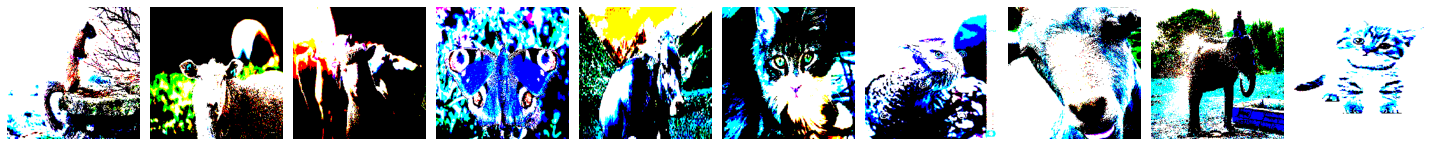

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [39]:
plotImages(imgs)
print(labels)

** DOWNLOADING VGG16 MODEL**

In [40]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [41]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

**ADDING VGG16 TO OUR MODEL EXCEPT THE LAST LAYER**


In [42]:
model=Sequential()
for layers in vgg16_model.layers[:-1]:
  model.add(layers)

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [44]:
for layers in model.layers:
  layers.trainable = False

In [45]:
model.add(Dense(units=9, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [46]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
model.fit(x=train_batches, validation_data=valid_batches,epochs=5, verbose=2)

Epoch 1/5
91/91 - 544s - loss: 1.6207 - accuracy: 0.4978 - val_loss: 0.6683 - val_accuracy: 0.7611
Epoch 2/5
91/91 - 531s - loss: 0.3722 - accuracy: 0.8811 - val_loss: 0.3479 - val_accuracy: 0.8889
Epoch 3/5
91/91 - 532s - loss: 0.1976 - accuracy: 0.9427 - val_loss: 0.2597 - val_accuracy: 0.9222
Epoch 4/5
91/91 - 531s - loss: 0.1283 - accuracy: 0.9747 - val_loss: 0.2138 - val_accuracy: 0.9333
Epoch 5/5
91/91 - 532s - loss: 0.0867 - accuracy: 0.9879 - val_loss: 0.1985 - val_accuracy: 0.9389


**PREDICT/TEST**



In [48]:
predictions = model.predict(x=test_batches, verbose=0)

In [49]:
test_batches.classes 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], dtype=int32)

In [50]:
cm=confusion_matrix(y_true=test_batches.classes , y_pred=np.argmax(predictions, axis=-1) )

In [51]:
test_batches.class_indices

{'butterfly': 5,
 'cat': 3,
 'chicken': 4,
 'cow': 2,
 'dog': 8,
 'elephant': 6,
 'horse': 7,
 'sheep': 1,
 'squirrel': 0}

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[11  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  1  0]
 [ 0  0  0 10  0  0  0  0  1]
 [ 0  0  0  0 11  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  0 10  1  0]
 [ 0  0  2  1  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  0 11]]


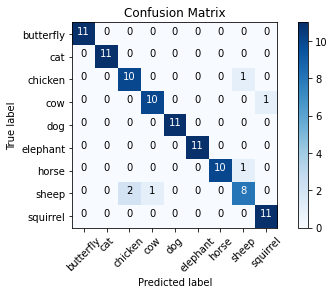

In [54]:
cm_plot_labels=['butterfly','cat','chicken','cow','dog','elephant','horse','sheep','squirrel']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')